In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras import backend as K, metrics
from keras.utils import to_categorical
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()
n = 2
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = False
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9947916666666665
 |>  150


In [5]:
n = 100
min_f = 3
max_f = 20
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
y_train = x_train

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.998958333333335
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9906250000000014
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0052083333333344
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.998958333333336
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9979166666666686
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9927083333333324
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.001041666666664
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9916666666666676
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666669
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9937500000000012
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9937499999999972
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.029166666666669
 |>  150
 [DEBUG] 

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9958333333333336
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9927083333333306
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0052083333333344
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.002083333333336
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.996874999999996
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.995833333333334
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9906249999999996
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0156250000000036
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9927083333333315
 |>  150


In [6]:
x_train.shape

(272, 150, 1)

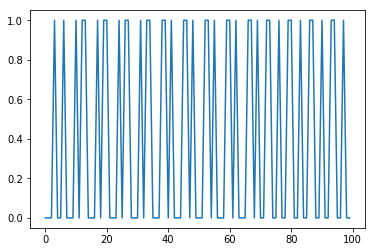

In [7]:
plt.plot(x_train[0,:100])

In [8]:
x_train.shape

(272, 150, 1)

In [9]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 150
input_shape

(150, 1)

In [10]:
output_shape

(150, 1)

In [11]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
# latent_dim = 1

In [17]:
# https://blog.keras.io/building-autoencoders-in-keras.html
def sampling(args, batch_size, latent_dim):
    # :args = 2 keras layers
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [12]:
k_reg = regularizers.l2(0.01)
# b_reg = regularizers.l1(0.01)
a_reg = regularizers.l1(0.01)

def encoder(input_shape, output_length, dropout=0.10):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = Flatten()(x)
#     x = Dense(150, activation='relu')(x)
    
    intermediate_dim = 100
    latent_dim = 100
    
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling)([z_mean, z_log_sigma])
    
    x = Dense(output_length, activation='relu')(x)
#     x = Dense(output_length, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    model = Model(inputs=input_layer, outputs=x)
    return model


def decoder(input_length, output_shape, dropout=0.10):
    input_layer = Input(shape=(input_length,))
    x = input_layer
    shape = output_shape
    # shape = (10,100) # increase n dimensions
    
    intermediate_dim = 100
    latent_dim = 100
    
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    
    
    x = Dense(150, activation='relu')(x)
#     x = Dense(150, activation='relu')(x)    

    x = Dense(np.prod(shape), activation='sigmoid')(x)
    x = Reshape(shape)(x)
    model = Model(inputs=input_layer, outputs=x)
    return model


def autoencoder(input_shape, output_shape, hidden_layer_length=10, dropout=0.10, verbose=False):
    input_ = Input(shape=input_shape)
    encode = encoder(input_shape, hidden_layer_length, dropout)
    if verbose:
        encode.summary()
    decode = decoder(hidden_layer_length, output_shape, dropout)
    if verbose:
        decode.summary()
    model = Model(input_, decode(encode(input_)))
    return encode, decode, model

dropout = 0.2
encoder, decoder, model = autoencoder(input_shape, output_shape, hidden_layer_length, dropout, True)

w1 300 w2 600
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 1)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
Total params: 45,300
Trainable params: 45,300
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150)               0         
__________________________________________________________

In [18]:
input_shape

(150, 1)

In [82]:
batch_size = 16
original_dim = 150
latent_dim = 50
intermediate_dim = 150
epochs = 50
epsilon_std = 1.0

In [83]:
encoder_input = Input(shape=(150,))
# x = Input(shape=(input_shape[0],))
# encoder_input = Input(shape=input_shape)
x = encoder_input

# x = Reshape((input_shape[0],))(x)
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
# x_decoded_mean = Reshape(input_shape)(x_decoded_mean)

vae = Model(encoder_input, x_decoded_mean)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 150)          22650       input_33[0][0]                   
__________________________________________________________________________________________________
dense_101 (Dense)               (None, 50)           7550        dense_100[0][0]                  
__________________________________________________________________________________________________
dense_102 (Dense)               (None, 50)           7550        dense_100[0][0]                  
__________________________________________________________________________________________________
lambda_20 

In [84]:
# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(encoder_input, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Output "dense_104" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_104" during training.
  import sys


In [85]:
# z_train = x_train
x_train = x_train.reshape(x_train.shape[0],np.prod(x_train.shape[1:]))
x_train.shape

(242, 150)

In [86]:
x_test = x_train[-10:].astype('float32')
x_train = x_train[:-10].astype('float32')

In [87]:
vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 232 samples, validate on 10 samples
Epoch 1/50
232/232 [==============================] - 1s 3ms/step - loss: 103.8794 - val_loss: 93.7028
Epoch 2/50
232/232 [==============================] - 0s 172us/step - loss: 97.0716 - val_loss: 92.7686
Epoch 3/50
232/232 [==============================] - 0s 195us/step - loss: 95.0384 - val_loss: 92.6100
Epoch 4/50
232/232 [==============================] - 0s 185us/step - loss: 93.5969 - val_loss: 89.8824
Epoch 5/50
232/232 [==============================] - 0s 181us/step - loss: 92.6800 - val_loss: 88.8854
Epoch 6/50
232/232 [==============================] - 0s 192us/step - loss: 91.8105 - val_loss: 89.2199
Epoch 7/50
232/232 [==============================] - 0s 188us/step - loss: 91.3586 - val_loss: 89.8837
Epoch 8/50
232/232 [==============================] - 0s 183us/step - loss: 90.2961 - val_loss: 86.4807
Epoch 9/50
232/232 [==============================] - 0s 187us/step - loss: 89.9638 - val_loss: 90.1510
Epoch 10/50
232/232 

In [88]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 150)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 150)               22650     
_________________________________________________________________
dense_101 (Dense)            (None, 50)                7550      
Total params: 30,200
Trainable params: 30,200
Non-trainable params: 0
_________________________________________________________________


In [90]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 50)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 150)               7650      
_________________________________________________________________
dense_104 (Dense)            (None, 150)               22650     
Total params: 30,300
Trainable params: 30,300
Non-trainable params: 0
_________________________________________________________________


In [13]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'adam' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy'])#, metrics=metrics)

In [14]:
batch_size = 16
# n epochs = n iterations over all the training data
epochs = 50

In [100]:
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
vs = 1/6
m = 100
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = model.fit(x_train[:m],x_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks)

Train on 83 samples, validate on 17 samples
Epoch 1/50
83/83 [==============================] - 0s 3ms/step - loss: 0.6915 - mean_squared_error: 0.2492 - mean_absolute_error: 0.4974 - acc: 0.5315 - val_loss: 0.6808 - val_mean_squared_error: 0.2438 - val_mean_absolute_error: 0.4919 - val_acc: 0.5933
Epoch 2/50
83/83 [==============================] - 0s 301us/step - loss: 0.6714 - mean_squared_error: 0.2392 - mean_absolute_error: 0.4863 - acc: 0.6282 - val_loss: 0.6683 - val_mean_squared_error: 0.2376 - val_mean_absolute_error: 0.4827 - val_acc: 0.6396
Epoch 3/50
83/83 [==============================] - 0s 253us/step - loss: 0.6506 - mean_squared_error: 0.2290 - mean_absolute_error: 0.4711 - acc: 0.6668 - val_loss: 0.6544 - val_mean_squared_error: 0.2306 - val_mean_absolute_error: 0.4669 - val_acc: 0.6569
Epoch 4/50
83/83 [==============================] - 0s 291us/step - loss: 0.6257 - mean_squared_error: 0.2172 - mean_absolute_error: 0.4472 - acc: 0.6823 - val_loss: 0.6466 - val_mean_

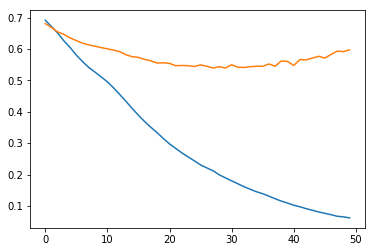

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

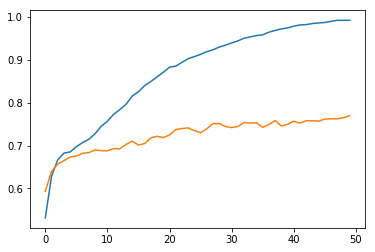

In [102]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

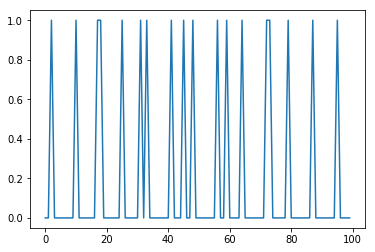

In [35]:
plt.plot(x_train[0,:100,:])

In [19]:
result.shape

NameError: name 'result' is not defined

In [ ]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)